# 1 - Project Overview

## Custom CNN for Image Classification

This notebook implements a Convolutional Neural Network (CNN) for image classification using TensorFlow/Keras.  
It covers:
- Loading and preprocessing images
- Dataset optimization
- Model building (custom CNN)
- Training with early stopping
- Evaluation on a test set

# 2 - Imports & Environment Setup

In [18]:
import os, zipfile, glob, shutil, sys
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report

# 3 - Dataset Loading

> Global variables

In [2]:
IMG_SIZE = (224, 224) # Image size for the network
BATCH_SIZE = 20       # Number of images per batch
SEED = 42

> We load the images from the local directories (Google Drive) for train, validation, and test sets.

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Folder where zip is located
CNN_PROJECT_DIR = '/content/drive/MyDrive/CNN_Project'
EXTRACT_DIR = CNN_PROJECT_DIR
DATA_DIR = os.path.join(EXTRACT_DIR, 'data')

Mounted at /content/drive


> Extract the Zip

In [ ]:
# Find the first zip file in the folder
zip_candidates = glob.glob(os.path.join(CNN_PROJECT_DIR, '*.zip'))
assert len(zip_candidates) >= 1, f"No .zip found in {CNN_PROJECT_DIR}. Put your data zip there."
ZIP_PATH = zip_candidates[0]
print("Using ZIP:", ZIP_PATH)

# Extract in the same folder as the zip
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

# Expecting:
for sub in ['train', 'validation', 'test']:
    path = os.path.join(DATA_DIR, sub)
    print(sub, "exists:", os.path.isdir(path), path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using ZIP: /content/drive/MyDrive/CNN_Project/data.zip
train exists: True /content/drive/MyDrive/CNN_Project/data/train
validation exists: True /content/drive/MyDrive/CNN_Project/data/validation
test exists: True /content/drive/MyDrive/CNN_Project/data/test


In [4]:
# Load train dataset
train_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# Load validation dataset
val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'validation'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Load test dataset
test_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 13412 files belonging to 6 classes.
Found 2549 files belonging to 6 classes.
Found 1845 files belonging to 6 classes.


> Display Simples

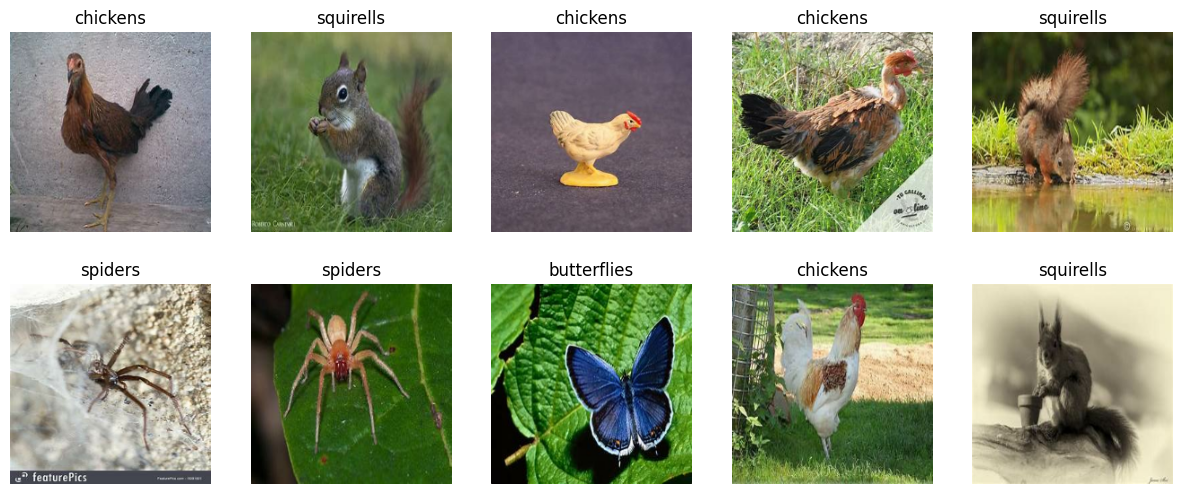

In [5]:
# Get one batch from the dataset
images, labels = next(iter(train_ds))
class_names = train_ds.class_names

# Plot 10 images
plt.figure(figsize=(15, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

# 4 - Dataset Preprocessing & Optimization

- Convert images to float32
- Apply VGG16 preprocessing (BGR + mean subtraction)
- Optimize dataset pipeline with caching and prefetching

> Preprocessing function for each image

In [6]:
# VGG16 expects BGR + mean subtraction
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label

# List of class names
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# Enable parallel preprocessing
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.map(preprocess,   num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(preprocess,  num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

Classes: ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']


> Display preprocessed simples

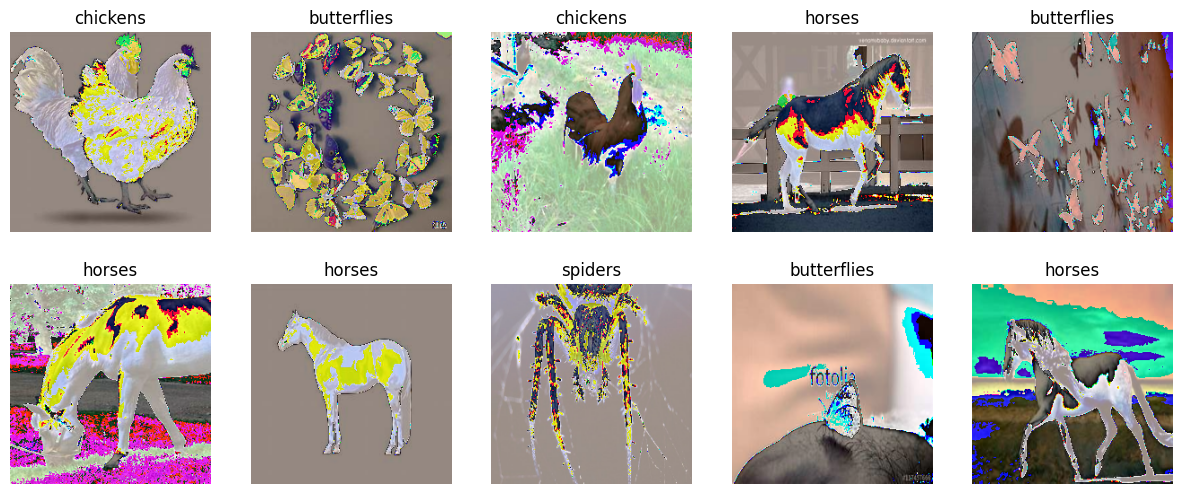

In [7]:
# Get one batch from the dataset
images, labels = next(iter(train_ds))

# Plot 10 images
plt.figure(figsize=(15, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()

# 5 - Model Building

> Custom CNN Model

In [ ]:
custom_cnn = keras.Sequential([
    layers.Conv2D(32, padding="same",kernel_size=(3,3), activation="relu", input_shape = IMG_SIZE + (3,)),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),
    layers.Conv2D(64, padding="same",kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2), strides=2),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
], name="custom_cnn")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


> Compile model with Adam optimizer

In [ ]:
custom_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

custom_cnn.summary()

Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,401,414 (196.08 MB)

 Trainable params: 51,401,414 (196.08 MB)

 Non-trainable params: 0 (0.00 B)

# 6 - Model Training

> Model Training

- Early stopping to prevent overfitting
- Train for 25 epochs max

In [ ]:
early = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=6, restore_best_weights=True
)

history_custom = custom_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early]
)

Epoch 1/10
239/671 ━━━━━━━━━━━━━━━━━━━━ 53:51 7s/step - accuracy: 0.3105 - loss: 98.9836

# 7 - Model Evaluation

> Model Evaluation on Test Set

In [ ]:
# Evaluate on test set
test_loss, test_acc = custom_cnn.evaluate(test_ds)
print(f"Custom CNN Test Acc: {test_acc:.4f}")

> Plot Accuracy / loss

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_custom.history['accuracy'], label='train_acc')
plt.plot(history_custom.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history_custom.history['loss'], label='train_loss')
plt.plot(history_custom.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()

> Plot Confusion matrix

In [ ]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(custom_cnn.predict(test_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

> Save Model

In [ ]:
custom_cnn.save("custom_cnn_model.h5")

# 8 - Fine-Tuning VGG16

> Create Vgg16 model

In [10]:
vgg16_model = tf.keras.applications.VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

> Create new model (Delete prediction layer)

In [15]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

> Freeze Model Weights

In [16]:
for layer in model.layers:
    layer.trainable = False

> Add new Prediction layer (6 classes)

In [19]:
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,285,126 (512.26 MB)

 Trainable params: 24,582 (96.02 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

> Compile the model

In [20]:
model.compile(optimizer=keras.optimizers.Adam(0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

> Train the Model

In [ ]:
model.fit(x=train_ds, validation_data=val_ds, epochs=10, verbose=1)

Epoch 1/10
321/671 ━━━━━━━━━━━━━━━━━━━━ 19:16 3s/step - accuracy: 0.9159 - loss: 0.2727

> Evaluate the model

In [ ]:
loss, acc = model.evaluate(val_ds, verbose=1)
print(f"\nFinal Evaluation -> Loss: {loss:.4f}, Accuracy: {acc:.4f}")

In [ ]:
# Get predicted probabilities for all test samples
y_pred_probs = model.predict(test_ds)

# Convert to predicted class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True class indices (from dataset labels)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Example: compare first 10 predictions with true labels
print("True labels:     ", y_true[:10])
print("Predicted labels:", y_pred_classes[:10])